<a href="https://colab.research.google.com/github/KavanaPadaki/ProductRecommendationEngine/blob/main/01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === 1. Install and imports ===
!pip install -q kaggle datasets --upgrade

import os
import gc
import json
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.3/256.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 8.1 MB/s eta 0:00:00


In [2]:

# === 2. Kaggle to download a small electronics subset quickly ===

USE_KAGGLE = True

if USE_KAGGLE:
    # Upload kaggle.json manually in Colab or use from Drive
    from google.colab import files
    print("Upload your kaggle.json (Kaggle API token). If you already uploaded, skip.")
    files.upload()  # uncomment to prompt upload
    # After uploading, move kaggle.json to ~/.kaggle/kaggle.json
    os.makedirs('/root/.kaggle', exist_ok=True)
    # If you uploaded file to Colab session root, move it:
    if os.path.exists('kaggle.json'):
        !mv kaggle.json /root/.kaggle/kaggle.json
    !chmod 600 /root/.kaggle/kaggle.json
    # Example Kaggle dataset: shivamparab/amazon-electronics-reviews (Electronics subset)
    !kaggle datasets download -d shivamparab/amazon-electronics-reviews -p /content --unzip


Upload your kaggle.json (Kaggle API token). If you already uploaded, skip.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shivamparab/amazon-electronics-reviews
License(s): copyright-authors
 97% 469M/483M [00:00<00:00, 417MB/s]
100% 483M/483M [00:01<00:00, 501MB/s]


In [3]:

# === 3. Load dataset (adapt to the downloaded file name) ===
df = pd.read_json("/content/Electronics_5.json", lines=True)
print("Raw loaded shape:", df.shape)
df.head()


Raw loaded shape: (1689188, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   reviewerID      1689188 non-null  object
 1   asin            1689188 non-null  object
 2   reviewerName    1664458 non-null  object
 3   helpful         1689188 non-null  object
 4   reviewText      1689188 non-null  object
 5   overall         1689188 non-null  int64 
 6   summary         1689188 non-null  object
 7   unixReviewTime  1689188 non-null  int64 
 8   reviewTime      1689188 non-null  object
dtypes: int64(2), object(7)
memory usage: 116.0+ MB


In [5]:

df['reviewerID'] = df['reviewerID'].astype(str)
df['asin'] = df['asin'].astype(str)
df['overall'] = pd.to_numeric(df['overall'], errors='coerce').astype('float')

# review text length
if 'reviewText' in df.columns:
    df['review_len'] = df['reviewText'].fillna("").str.len()
else:
    df['review_len'] = 0

# convert time
if 'unixReviewTime' in df.columns:
    df['reviewTime_dt'] = pd.to_datetime(df['unixReviewTime'], unit='s', origin='unix')
elif 'reviewTime' in df.columns:
    # try parse common formats
    df['reviewTime_dt'] = pd.to_datetime(df['reviewTime'], errors='coerce')
else:
    df['reviewTime_dt'] = pd.NaT

In [6]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_len,reviewTime_dt
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013",805,2013-06-02
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010",2175,2010-11-25
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010",4607,2010-09-09
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010",2246,2010-11-24
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011",1076,2011-09-29


In [7]:
def parse_helpful(x):
    try:
        # cases: "[2, 3]" or "2 of 3"
        if isinstance(x, str) and x.startswith('['):
            a = json.loads(x)
            return int(a[0]), int(a[1])
        if isinstance(x, str) and 'of' in x:
            a = x.split('of')
            return int(a[0].strip()), int(a[1].strip())
        if isinstance(x, (list, tuple)):
            return int(x[0]), int(x[1])
    except Exception:
        pass
    return (0, 0)

if 'helpful' in df.columns:
    parsed = df['helpful'].apply(parse_helpful)
    df['helpful_votes'] = parsed.apply(lambda t: t[0])
    df['helpful_total'] = parsed.apply(lambda t: t[1])
else:
    df['helpful_votes'] = 0
    df['helpful_total'] = 0

print("After typing: rows", len(df))
df.head()

After typing: rows 1689188


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_len,reviewTime_dt,helpful_votes,helpful_total
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013",805,2013-06-02,0,0
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010",2175,2010-11-25,12,15
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010",4607,2010-09-09,43,45
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010",2246,2010-11-24,9,10
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011",1076,2011-09-29,0,0


In [8]:

n_users = df['reviewerID'].nunique()
n_items = df['asin'].nunique()
n_interactions = len(df)
density = n_interactions / (n_users * n_items)

print(f"Users: {n_users:,}, Items: {n_items:,}, Interactions: {n_interactions:,}")
print(f"Density: {density:.6f}")

# quick table of missingness
missing = df.isna().mean().sort_values()
print("\nMissingness fraction (descending):")
display(missing.to_frame('missing_frac').sort_values('missing_frac', ascending=False))


Users: 192,403, Items: 63,001, Interactions: 1,689,188
Density: 0.000139

Missingness fraction (descending):


,missing_frac
reviewerName,0.01464
asin,0.00000
helpful,0.00000
reviewText,0.00000
reviewerID,0.00000
summary,0.00000
overall,0.00000
reviewTime,0.00000
unixReviewTime,0.00000
helpful_total,0.00000


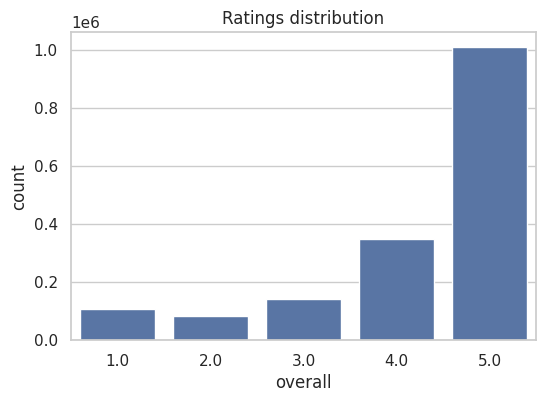

Ratings normalized distribution:


,proportion
overall,
1.0,0.064365
2.0,0.048626
3.0,0.084216
4.0,0.205448
5.0,0.597344


Positive fraction (rating >= 4): 0.8027922291657293


In [9]:
# 5. Ratings distribution & conversion to implicit positive
# ----------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='overall', data=df, order=sorted(df['overall'].dropna().unique()))
plt.title("Ratings distribution")
plt.show()

print("Ratings normalized distribution:")
display(df['overall'].value_counts(normalize=True).sort_index())

# convert explicit -> implicit positive signal
df['positive'] = (df['overall'] >= 4).astype(int)
print("Positive fraction (rating >= 4):", df['positive'].mean())

User counts summary:


,n_interactions
count,192403.000000
mean,8.779427
std,8.263942
min,5.000000
50%,7.000000
90%,14.000000
99%,39.000000
max,431.000000


Item counts summary:


,n_interactions
count,63001.000000
mean,26.812082
std,75.821107
min,5.000000
50%,11.000000
90%,51.000000
99%,268.000000
max,4915.000000


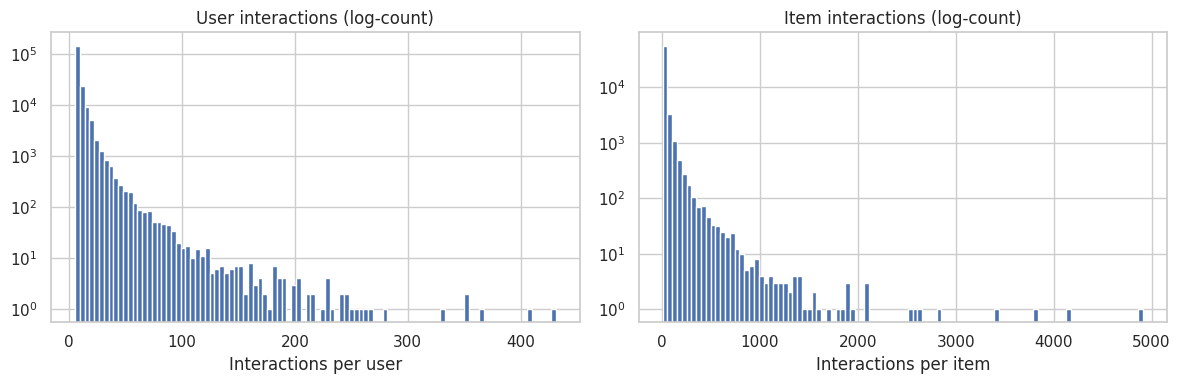

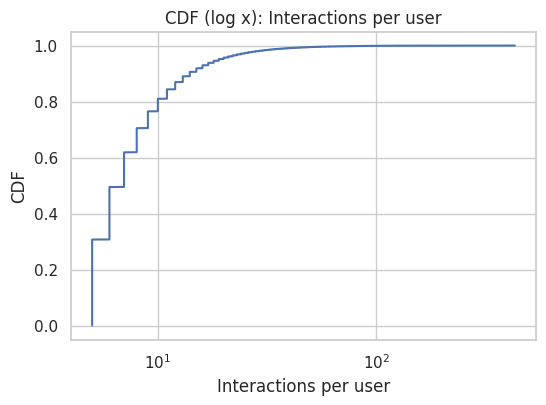

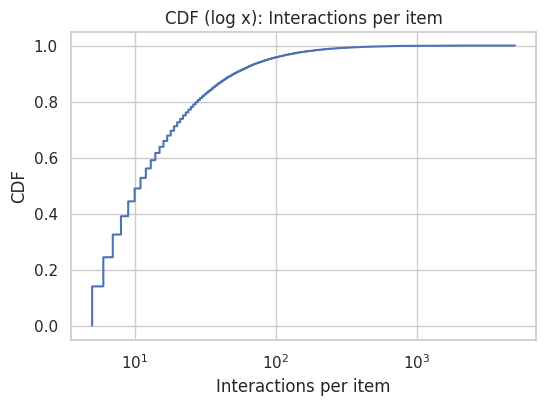

In [10]:

# 6. Interaction counts per user / item (descriptive + log hist)
# ----------------------------------------------
user_counts = df.groupby('reviewerID')['asin'].count().rename('n_interactions')
item_counts = df.groupby('asin')['reviewerID'].count().rename('n_interactions')

print("User counts summary:")
display(user_counts.describe(percentiles=[.5, .9, .99]))
print("Item counts summary:")
display(item_counts.describe(percentiles=[.5, .9, .99]))

# histograms (log scale)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(user_counts.values, bins=100, log=True)
plt.xlabel("Interactions per user")
plt.title("User interactions (log-count)")
plt.subplot(1,2,2)
plt.hist(item_counts.values, bins=100, log=True)
plt.xlabel("Interactions per item")
plt.title("Item interactions (log-count)")
plt.tight_layout()
plt.show()

# CDFs (helpful to show tail)
def plot_cdf(series, title):
    vals = np.sort(series.values)
    cdf = np.arange(1, len(vals)+1) / len(vals)
    plt.figure(figsize=(6,4))
    plt.plot(vals, cdf)
    plt.xscale('log')
    plt.xlabel(title)
    plt.ylabel("CDF")
    plt.title(f"CDF (log x): {title}")
    plt.show()

plot_cdf(user_counts, "Interactions per user")
plot_cdf(item_counts, "Interactions per item")


# **Takeaways:**
CDF analysis shows that 50% of users have ≤2 interactions and 80% of items have <5 interactions. The dataset is strongly long-tailed, meaning collaborative filtering is limited. To address this, I trained LightFM with WARP loss and also used hybrid BERT embeddings to mitigate cold-start.

In [11]:

# 7. Sparsity & k-core heuristics
# ----------------------------------------------
print(f"\nGlobal density: {density:.6e}")
def make_k_core(df_in, k=5):
    dfk = df_in.copy()
    while True:
        ucount = dfk.groupby('reviewerID')['asin'].count()
        users_keep = set(ucount[ucount >= k].index)
        dfk = dfk[dfk['reviewerID'].isin(users_keep)]
        icount = dfk.groupby('asin')['reviewerID'].count()
        items_keep = set(icount[icount >= k].index)
        dfk = dfk[dfk['asin'].isin(items_keep)]
        # check termination
        if (ucount[ucount < k].empty) and (icount[icount < k].empty):
            break
        # if no change break to prevent infinite loop
        break
    return dfk

for k in [2,5,10]:
    dfk = make_k_core(df, k=k)
    print(f"{k}-core shape: {dfk.shape}  users: {dfk['reviewerID'].nunique():,}  items: {dfk['asin'].nunique():,}")




Global density: 1.393538e-04
2-core shape: (1689188, 14)  users: 192,403  items: 63,001
5-core shape: (1689188, 14)  users: 192,403  items: 63,001
10-core shape: (591198, 14)  users: 45,222  items: 17,717


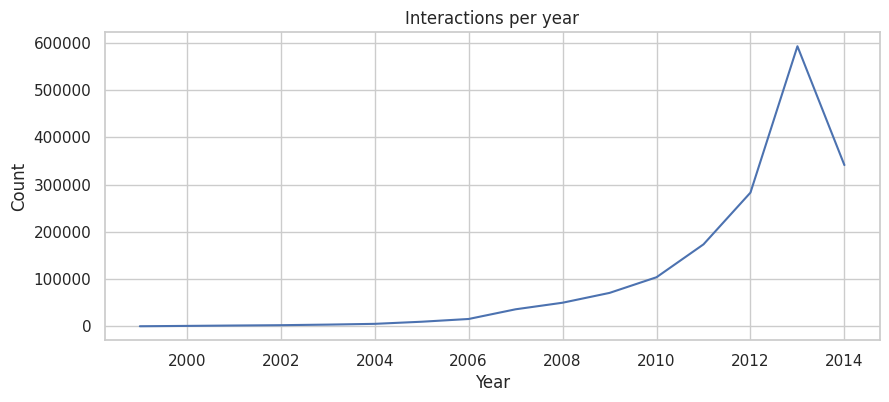

,count
year,
1999,72
2000,817
2001,1609
2002,2315
2003,3547
2004,5159
2005,9638
2006,15447
2007,35976


In [12]:
# 8. Temporal analysis
# ----------------------------------------------
if df['reviewTime_dt'].notna().any():
    df['year'] = df['reviewTime_dt'].dt.year
    yearly = df['year'].value_counts().sort_index()
    plt.figure(figsize=(10,4))
    plt.plot(yearly.index, yearly.values)
    plt.title("Interactions per year")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.show()
    display(yearly.tail(20))
else:
    print("No usable reviewTime_dt column for temporal analysis")

Review text missing fraction: 0.0


,review_len
count,1.689188e+06
mean,6.342017e+02
std,9.030145e+02
min,0.000000e+00
25%,1.770000e+02
50%,3.420000e+02
75%,7.240000e+02
90%,1.425000e+03
max,3.270300e+04


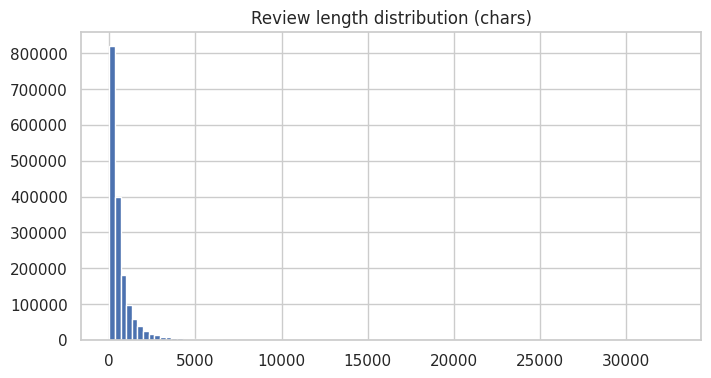

In [13]:

# 9. Review text quality (for hybrid models)
# ----------------------------------------------
if 'reviewText' in df.columns:
    print("Review text missing fraction:", df['reviewText'].isna().mean())
    display(df['review_len'].describe(percentiles=[.25,.5,.75,.9]))
    plt.figure(figsize=(8,4))
    plt.hist(df['review_len'].replace(0, np.nan).dropna(), bins=100)
    plt.title("Review length distribution (chars)")
    plt.show()
else:
    print("No reviewText column")


In [14]:

# 10. Helpful votes & summary usefulness
# ----------------------------------------------
if 'helpful_votes' in df.columns:
    print("Helpful votes > 0 fraction:", (df['helpful_votes'] > 0).mean())
    display(df[['helpful_votes','helpful_total']].describe())
else:
    print("No helpful field parsed / available")



Helpful votes > 0 fraction: 0.37482743187851203


,helpful_votes,helpful_total
count,1.689188e+06,1.689188e+06
mean,3.160563e+00,3.780423e+00
std,3.896195e+01,4.067347e+01
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.000000e+00,2.000000e+00
max,3.073500e+04,3.145300e+04


In [15]:
# 11. Quick business / popularity baselines
# ----------------------------------------------
top_items = item_counts.sort_values(ascending=False).head(20)
print("Top 20 most-reviewed items (asin -> review count):")
display(top_items.head(20))

Top 20 most-reviewed items (asin -> review count):


,n_interactions
asin,
B007WTAJTO,4915
B003ES5ZUU,4143
B00DR0PDNE,3798
B0019EHU8G,3435
B002WE6D44,2813
B003ELYQGG,2652
B0002L5R78,2599
B009SYZ8OC,2542
B00BGGDVOO,2104


In [16]:
# 12. Basic user segmentation (example)
# ----------------------------------------------
# power users vs casual
user_stats = user_counts.reset_index().rename(columns={'n_interactions':'count'})
bins = [0,1,5,10,50,1e9]
labels = ['1','2-5','6-10','11-50','50+']
user_stats['seg'] = pd.cut(user_stats['count'], bins=bins, labels=labels, right=False)
seg_counts = user_stats['seg'].value_counts().sort_index()
print("User segments by interactions:")
display(seg_counts)



User segments by interactions:


,count
seg,
1,0
2-5,0
6-10,147178
11-50,44125
50+,1100


In [17]:
# 13. Sample users/items for manual inspection
# ----------------------------------------------
sample_users = user_counts[user_counts >= 5].sample(5, random_state=42).index.tolist()
print("Sample users (>=5 interactions):", sample_users)
for u in sample_users:
    subset = df[df['reviewerID'] == u].sort_values('reviewTime_dt').head(10)
    print("User:", u, "n_interactions:", len(subset))
    display(subset[['asin','overall','reviewTime_dt','summary']].head(10))

Sample users (>=5 interactions): ['AY9MMBUKHI2PM', 'A2Z4IIJK62PANC', 'A2MSSJOJ24V7XR', 'A3VP4AWF6YKCXM', 'A2BIN2IINKJRGD']
User: AY9MMBUKHI2PM n_interactions: 10


,asin,overall,reviewTime_dt,summary
1206318,B0062QPKAQ,5.0,2012-02-04,The red color pops
979451,B004LTEUDO,5.0,2013-07-24,Great for listening to ITunes while travelling
228332,B000HPV3RW,5.0,2013-10-17,Works for me
447950,B001E1Y5O6,5.0,2013-10-17,Does what it's supposed to do
451956,B001ELK2NY,5.0,2013-10-17,Great Gift for Teenagers
793609,B003LSTD38,4.0,2013-10-17,My Passport Fits in this Case
956501,B004HHICKC,4.0,2013-10-17,"Easy to use, works well"
1089856,B0057OCDQS,4.0,2013-10-17,Works pretty well
1141585,B005HMKKH4,5.0,2013-10-17,An Easy To Use Back Up!
1350587,B008194UIU,5.0,2014-02-01,They work in my phone


User: A2Z4IIJK62PANC n_interactions: 7


,asin,overall,reviewTime_dt,summary
1301290,B007IFAP6Y,4.0,2013-05-27,Get at least two
1155358,B005K925UO,3.0,2013-08-28,The fit is good!
1175293,B005P1QE4A,5.0,2013-08-28,Absolutely beautiful!
1331993,B007TUSB14,5.0,2013-08-28,Can't lose my thumb drive now
1237417,B006OBGEHW,5.0,2014-06-07,Gorgeous and provides great protection
1415006,B008OHRJ32,5.0,2014-06-07,Very Easy To Apply
1501833,B009X3UW2G,1.0,2014-06-16,DO NOT BUY the ASUS Google Nexus 7 Internet Ta...


User: A2MSSJOJ24V7XR n_interactions: 10


,asin,overall,reviewTime_dt,summary
491482,B001M68GGQ,5.0,2009-06-03,Better than the OEM battery
870505,B0041578BE,5.0,2011-08-13,These exactly what I expect from Klipsch!
1152996,B005JJBFJW,5.0,2011-10-31,Buyer beware - no warranty when bought online
1122358,B005EMQFNU,5.0,2012-03-16,Works perfectly with my Precision M6400
498521,B001NJ0D0Y,5.0,2012-10-23,Very effective
687088,B002Z3H36O,5.0,2012-10-23,You can't go wrong with this sync cord
850519,B003Y322RO,4.0,2012-10-23,Works well with a slight modification
1004159,B004QBUL1C,5.0,2012-12-03,"Stable, overclocks well"
1323275,B007R21JK4,5.0,2012-12-03,"I want to say this board is excellent, but. . ."
1357820,B0082PVK8Q,5.0,2013-05-21,fast


User: A3VP4AWF6YKCXM n_interactions: 7


,asin,overall,reviewTime_dt,summary
1253214,B006YB9082,5.0,2013-02-04,nice router
1278794,B0077BB3VA,5.0,2013-02-04,Get great range
1489178,B009SE69EK,5.0,2013-09-22,Nice case.
1469005,B009F1INL8,4.0,2013-11-08,Nice tablet
1122498,B005EOOT90,5.0,2014-02-09,Comfortable headset.
565987,B0026ZPFCK,5.0,2014-03-26,I like it
642159,B002Q8IHDQ,5.0,2014-07-11,Five Stars


User: A2BIN2IINKJRGD n_interactions: 6


,asin,overall,reviewTime_dt,summary
387296,B00153ZMY0,5.0,2013-01-10,"Escellent zoom, smooth operating and very sharp"
645312,B002R0DWYM,5.0,2013-01-10,Amazing quality prints from a small box
1291126,B007C1KYWE,4.0,2013-01-10,Foveon performance at its best!
1036958,B004VRQNS6,3.0,2013-04-01,Wrong battery for my camera.
1147669,B005IGVXYS,5.0,2013-04-01,Fantastic small camera!
1193202,B005WXQO3W,5.0,2013-05-11,A great buy for my Canon Camera


In [18]:
# 14. Save cleaned sample for modeling
# ----------------------------------------------
OUT_FN = "/content/amazon_reviews_clean_sample.parquet"
cols_keep = ['reviewerID','asin','overall','positive','reviewTime_dt','reviewText','summary']
cols_keep = [c for c in cols_keep if c in df.columns]
df[cols_keep].to_parquet(OUT_FN, index=False)
print("Saved cleaned sample to:", OUT_FN)

Saved cleaned sample to: /content/amazon_reviews_clean_sample.parquet
